# exploration 5번째 과제</br>
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [10]:
import glob
import os
import numpy as np

from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## 상수선언

In [11]:
DATA_PATH = "/".join([str(Path("./").parent.resolve().parent.resolve().parent.resolve().absolute()).replace("\\","/"),"data","rock_scissor_paper"]) # 데이터 기본경로
TRAIN_DATA_PATH = "/".join([DATA_PATH, "train"]) # 학습용 데이터
TEST_DATA_PATH = "/".join([DATA_PATH, "test"]) # 예측용 데이터
SUB_DATA_FOLDER = ["scissor", "rock", "paper"] # 가위바위보 폴더명
# `train_test_split`설정
train_test_split_kwargs = {
    "test_size":0.2
    , "random_state":42
}

# `model.fit`설정
fit_kwargs = {
    "epochs":32
    , "batch_size":128
    , "verbose":1
    , "validation_freq":8
}

## 함수선언

In [12]:
def resize_images(img_path: str) -> None:
    """
    폴더안의 이미지 파일을 전부 28*28사이즈로 변환 

    Parameters
    ----------
    img_path : str
        이미지 경로

    Returns
    ----------
    None
    """
    images=glob.glob(img_path + "/*.jpg")  

    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.LANCZOS)
        new_img.save(img, "JPEG")
    
    print(len(images), " 개의 이미지가 변환되었습니다.")

def load_data(img_path:str, number_of_data:int=1800):
    """
    가위, 바위, 보의 이미지를 불러오고\n
    각 이미지에 맞는 라벨을 생성하여\n
    이미지 변수와 라벨변수를 각각 리턴한다.\n
    각 이미지에 메칭되는 숫자는 아래와 같다.\n
     - 가위 : 0
     - 바위 : 1
     - 보 : 2

    Parameters
    ----------
    img_path : str
        불러올 이미지의 경로\n
        가위, 바위, 보의 상위 경로로 설정한다.

    Returns
    ----------
    residual : Series
        
    """
    img_size=28 # 이미지 크기
    color=3 # RGB

    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for i, sub in enumerate(SUB_DATA_FOLDER):
        for file in glob.iglob(img_path+f'/{sub}/*.jpg'): # 가위, 바위, 보
            img = np.array(Image.open(file),dtype=np.int32)
            imgs[idx,:,:,:]=img
            labels[idx]=i 
            idx=idx+1
        
    print(f"{img_path}안의 데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

## 메인

In [13]:
for sub_f in SUB_DATA_FOLDER:
    resize_images(os.path.join(TRAIN_DATA_PATH, sub_f))
    resize_images(os.path.join(TEST_DATA_PATH, sub_f))

# 데이터 로드
(x_train, y_train), (x_test, y_test)=load_data(TRAIN_DATA_PATH), load_data(TEST_DATA_PATH)

C:\Users\Owner\AppData\Local\Temp\ipykernel_9872\2095284131.py:19: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.LANCZOS)


600  개의 이미지가 변환되었습니다.
100  개의 이미지가 변환되었습니다.
600  개의 이미지가 변환되었습니다.
100  개의 이미지가 변환되었습니다.
600  개의 이미지가 변환되었습니다.
100  개의 이미지가 변환되었습니다.
C:/workspace/project_so/data/rock_scissor_paper/train안의 데이터의 이미지 개수는 1800 입니다.
C:/workspace/project_so/data/rock_scissor_paper/test안의 데이터의 이미지 개수는 300 입니다.


`train`과 `test`데이터를 각각 불러왔으며 각각 1800장, 300장으로 6:1 비율로 나누었다.</br>
딥러닝의 특성상 많은 데이터를 학습시킬수록 성능이 좋아지므로</br>
본인의 300장을 제외한 나머지 분은 조원들의 협조를 구해 구하였다.</br>

In [14]:
# 입력은 0~1 사이의 값으로 정규화
x_train_norm = x_train/255.0   
x_test_norm = x_test/255.0

x_train_norm, x_val_norm, y_train, y_val = train_test_split(x_train_norm, y_train, **train_test_split_kwargs)

# train reshape
x_train_reshaped=x_train_norm.reshape(-1, 28, 28, 3)
print(f"x_train_reshaped : {x_train_reshaped.shape}")
x_val_reshaped=x_val_norm.reshape(-1, 28, 28, 3)
print(f"x_val_reshaped : {x_val_reshaped.shape}")

x_train_reshaped : (1440, 28, 28, 3)
x_val_reshaped : (360, 28, 28, 3)


`train`과 `test`데이터를 R,G,B각각 화소의 최대값으로 나누어 정규화</br>
`train`데이터는 검증용과 학습용으로 각각 2:8비율로 나누어서 과적합을 피하였다.

In [15]:
# 모델생성
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (

모델은 가위바위보의 이미지에 맞게 `input_shape`을 28*28 3체널로 변경

In [16]:

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(
    x_train_reshaped
    , y_train
    , validation_data=(x_val_reshaped, y_val)
    , **fit_kwargs
).history

Epoch 1/32
12/12 [==============================] - 0s 14ms/step - loss: 1.1017 - accuracy: 0.3424
Epoch 2/32
12/12 [==============================] - 0s 13ms/step - loss: 1.0913 - accuracy: 0.4174
Epoch 3/32
12/12 [==============================] - 0s 13ms/step - loss: 1.0869 - accuracy: 0.4139
Epoch 4/32
12/12 [==============================] - 0s 13ms/step - loss: 1.0816 - accuracy: 0.4264
Epoch 5/32
12/12 [==============================] - 0s 13ms/step - loss: 1.0747 - accuracy: 0.4111
Epoch 6/32
12/12 [==============================] - 0s 13ms/step - loss: 1.0664 - accuracy: 0.4229
Epoch 7/32
12/12 [==============================] - 0s 14ms/step - loss: 1.0487 - accuracy: 0.4590
Epoch 8/32
12/12 [==============================] - 0s 31ms/step - loss: 1.0339 - accuracy: 0.4917 - val_loss: 1.0397 - val_accuracy: 0.4889
Epoch 9/32
12/12 [==============================] - 0s 18ms/step - loss: 1.0196 - accuracy: 0.5014
Epoch 10/32
12/12 [==============================] - 0s 16ms/step -

`train` 데이터에 과적합 된 모델을 피하기 위해 `validation_data`를 설정하였다.</br>
데이터 검증은 8의 배수로 하였다.

In [17]:
# test
x_test_reshaped=x_test_norm.reshape(-1, 28, 28, 3)
print(f"x_test_reshaped : {x_test_reshaped.shape}")

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=1)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

x_test_reshaped : (1800, 28, 28, 3)
57/57 [==============================] - 0s 2ms/step - loss: 0.8202 - accuracy: 0.9489
test_loss: 0.8202298283576965
test_accuracy: 0.948888897895813


테스트 결과 `test_accuracy` 평균 약 95퍼 이상은 나오고 있으며</br>
`test_loss`는 0.6 ~ 0.9의 값이 랜덤으로 생성된다.

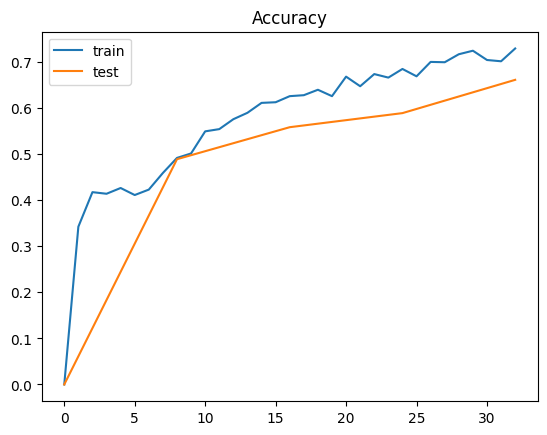

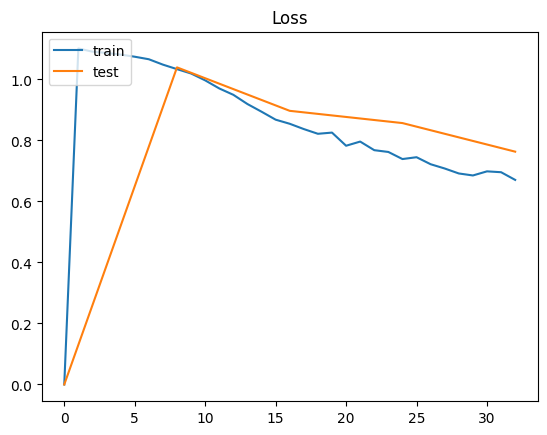

In [18]:
plt.plot(range(0, len(hist['accuracy'])+1), [0]+ hist['accuracy'])
plt.plot(range(0, len(hist['accuracy'])+1, fit_kwargs["validation_freq"]), [0]+ hist['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(range(0, len(hist['loss'])+1), [0]+ hist['loss'])
plt.plot(range(0, len(hist['loss'])+1, fit_kwargs["validation_freq"]), [0]+ hist['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

위에서부터 순서대로 
- `학습의 accurency`와 `검증의 accurency`의 증가추세를 그린 그래프
- `학습의 loss`와 `검증의 loss`의 감소추세를 그린 그래프

이다.</br>
`validate` 데이터는 4개밖에 없기때문에 4개의 점을 표시하고 각각 실선으로 이었다.</br>
</br>
학습의 정도에 따라
- `accurency` 그래프 두 선의 값이 대체로 상향
- `loss` 그래프 두 선의 값이 대체로 하향

이므로 학습의 문제는 없어보인다.

## 회고

- `test_loss`가 0.6 ~ 0.9정도 산출됨에도 불구하고 `test_accuracy` 평균은 약 95% 이상이다.</br>
  `test_loss`가 0.9가 산출된 케이스도 있었는데도 불구하고 `test_accuracy`가 여전히 90% 이상인 점이 특이하다.</br>
  아무리 독립적인 값이긴 하지만 결과가 의심스럽다.
- `train`과 `validate`가 각각 0.6 초과, 0.8 초과임에도 불구하고 실제 `test`데이터에서는 높은 적중률을 보였다.</br>
  이 점 또한 특이하다.